Charbel-Raphaël Segerie, Hugo Laurençon.

Here is the main notebook that allowed us to do the visualization and study the originality.

In [1]:
%cd drive/MyDrive/PatchMatch
#%mkdir PatchMatch
#%cd PatchMatch

/content/drive/MyDrive/PatchMatch


https://github.com/MingtaoGuo/PatchMatch/blob/master/PatchMatch.py

We were inspired by the code on the repository opposite. We are not the author of the PatchMatch algorithm. We simply accelerated it by using numba on the main routine and changing the call to the main function. However, we are the authors of all the visualizations and all the code that will follow this algorithm.

In [2]:
import numpy as np
from PIL import Image
from numba import jit
import matplotlib.pyplot as plt
import colorsys
from matplotlib.patches import Rectangle

np.random.seed(seed=0)
ITERATIONS = 10

nopython = True
@jit(nopython=nopython)
def cal_distance(a, b, A_padding, B_padding, p_size):
    patch_a = A_padding[a[0]:a[0]+p_size, a[1]:a[1]+p_size, :]
    patch_b = B_padding[b[0]:b[0]+p_size, b[1]:b[1]+p_size, :]
    temp = patch_b - patch_a
    num = 0
    dist = 0
    for i in range(p_size):
        for j in range(p_size):
            for k in range(3):
                if not np.isnan(temp[i,j,k]):
                    num +=1 
                    dist += np.square(temp[i,j,k])
    dist /= num
    return dist

def reconstruction(fi,fj, A, B):
    A_h = np.size(A, 0)
    A_w = np.size(A, 1)
    temp = np.zeros_like(A)
    for i in range(A_h):
        for j in range(A_w):
            temp[i, j, :] = B[fi[i, j], fj[i, j], :]
    Image.fromarray(temp).show()
    return temp
    
def initialization(A, B, p_size):
    A_h = np.shape(A)[0]
    A_w = np.shape(A)[1]
    B_h = np.shape(B)[0]
    B_w = np.shape(B)[1]
    p = p_size // 2
    random_B_r = np.random.randint(0, B_h-1, [A_h, A_w])
    random_B_c = np.random.randint(0, B_w-1, [A_h, A_w])
    A_padding = np.ones([A_h+p*2, A_w+p*2, 3]) * np.nan
    A_padding[p:A_h+p, p:A_w+p, :] = A
    
    B_padding = np.ones([B_h+p*2, B_w+p*2, 3]) * np.nan
    B_padding[p:B_h+p, p:B_w+p, :] = B
    
    fi = np.zeros([A_h, A_w],dtype=int)
    fj = np.zeros([A_h, A_w], dtype=int)
    dist = np.zeros([A_h, A_w])
    for i in range(A_h):
        for j in range(A_w):
            a = np.array([i, j])
            b = np.array([random_B_r[i, j], random_B_c[i, j]], dtype=np.int32)
            fi[i, j] = random_B_r[i, j]
            fj[i, j] = random_B_c[i, j]
            dist[i, j] = cal_distance(a, b, A_padding, B_padding, p_size)
    return fi,fj, dist, A_padding, B_padding

def random_search(fi,fj, a, dist, A_padding, B_padding, p_size, alpha=0.5):
    x = a[0]
    y = a[1]
    p = p_size // 2
    B_h = np.shape(B_padding)[0]-2*p
    B_w = np.shape(B_padding)[1]-2*p
    i = 4
    search_h = B_h * alpha ** i
    search_w = B_w * alpha ** i
    b_x = fi[x, y]
    b_y = fj[x, y]
    alpha=alpha
    while search_h > 1 and search_w > 1:
        search_min_r = max(b_x - search_h, 0)
        search_max_r = min(b_x + search_h, B_h-1)
        random_b_x = np.random.randint(search_min_r, search_max_r)
        search_min_c = max(b_y - search_w, 0)
        search_max_c = min(b_y + search_w, B_w-1)
        random_b_y = np.random.randint(search_min_c, search_max_c)
        search_h = B_h * alpha ** i
        search_w = B_w * alpha ** i
        b = np.array([random_b_x, random_b_y])
        d = cal_distance(a, b, A_padding, B_padding, p_size)
        if d < dist[x, y]:
            dist[x, y] = d
            fi[x, y] = b[0]
            fj[x, y] = b[1]
        i += 1
        

def propagation(fi,fj, a, dist, A_padding, B_padding, p_size, is_odd):
    A_h = np.shape(A_padding)[0] - p_size + 1
    A_w = np.shape(A_padding)[1] - p_size + 1
    x = a[0]
    y = a[1]
    if is_odd:
        i_left,j_left = fi[max(x - 1, 0), y],fj[max(x - 1, 0), y]
        i_left = min(i_left+1,A_h-1)
        b_left = np.array([i_left,j_left],dtype="int64")
        d_left = cal_distance(a,b_left, A_padding, B_padding, p_size)
        
        i_up,j_up = fi[x,max(y - 1, 0)],fj[x, max(y - 1, 0)]
        j_up = min(j_up+1,A_w-1)
        b_up = np.array([i_up,j_up],dtype="int64")
        d_up = cal_distance(a, b_up, A_padding, B_padding, p_size)
        
        d_current = dist[x, y]
        idx = np.argmin(np.array([d_current, d_left, d_up]))
        if idx == 1:
            fi[x, y] = i_left
            fj[x, y] = j_left
            dist[x, y] = d_left
        if idx == 2:
            fi[x, y] = i_up
            fj[x, y] = j_up
            dist[x, y] = d_up
    else:
        i_right,j_right = fi[min(x + 1, A_h-1), y],fj[min(x + 1, A_h-1), y]
        i_right = max(i_right-1,0)
        b_right = np.array([i_right,j_right],dtype="int64")
        d_right = cal_distance(a, b_right, A_padding, B_padding, p_size)
        
        i_down,j_down = fi[x, min(y + 1, A_w-1)],fj[x, min(y + 1, A_w-1)]
        j_down = max(j_down-1,0)
        b_down = np.array([i_down,j_down],dtype="int64")
        d_down = cal_distance(a, b_down, A_padding, B_padding, p_size)
        
        d_current = dist[x, y]
        idx = np.argmin(np.array([d_current, d_right, d_down]))
        if idx == 1:
            fi[x, y] = i_right
            fj[x, y] = j_right
            dist[x, y] = d_right
        if idx == 2:
            fi[x, y] = i_down
            fj[x, y] = j_down
            dist[x, y] = d_down
            
def NNS(img, ref, p_size, itr, verbose=True):
    A_h = np.size(img, 0)
    A_w = np.size(img, 1)
    if verbose:
        print("initialization")
    fi,fj, dist, img_padding, B_padding = initialization(img, ref, p_size)
    score_list = []
    for itr in range(1, itr+1):
        if itr % 2 == 0:
            for i in range(A_h - 1, -1, -1):
                for j in range(A_w - 1, -1, -1):
                    a = np.array([i, j])
                    propagation(fi,fj, a, dist, img_padding, B_padding, p_size, False)
                    random_search(fi,fj, a, dist, img_padding, B_padding, p_size)
        else:
            for i in range(A_h):
                for j in range(A_w):
                    a = np.array([i, j])
                    propagation(fi,fj, a, dist, img_padding, B_padding, p_size, True)
                    random_search(fi,fj, a, dist, img_padding, B_padding, p_size)
        if verbose:
            print(f"Iter : {itr}, score : {dist.mean()}")
        score_list.append(dist.mean())
    return fi,fj, dist, score_list
def show_offset(fi,fj,p_size, return_only_dist=True):
    di = np.zeros(fi.shape)
    dj = np.zeros(fi.shape)
    for i in range(fi.shape[0]):
        for j in range(fi.shape[1]):
            di[i,j] = i
            dj[i,j] = j
    offset_i = (fi-di)
    offset_j = (fj-dj)
    
    HSV = np.ones((offset_i.shape[0],offset_i.shape[1],3))
    for i in range(offset_i.shape[0]):
        for j in range(offset_i.shape[1]):
            x,y = offset_i[i,j]+10**-7,offset_j[i,j]+10**-7
            HSV[i,j][0] = (np.sqrt(x**2+y**2) + np.pi/2)/(2*np.pi)
            HSV[i,j][1] = (np.pi*(x<0) + np.arctan(y/x) + np.pi/2)/(2*np.pi)
            if return_only_dist:
                HSV[i,j][0] = np.sqrt(x**2+y**2)
    
    if return_only_dist:
        return HSV[:,:,0]
            
    HSV[:,:,0] /= HSV[:,:,0].max()
    
    RGB = np.zeros(HSV.shape)
    for i in range(offset_i.shape[0]):
        for j in range(offset_i.shape[1]):
            h,s,v = HSV[i,j,0] , HSV[i,j,1], 1
            RGB[i,j,:] = colorsys.hsv_to_rgb(h, s, v)
    
    #plt.imshow(RGB)
    #plt.show()
    return RGB
    
def main(orig_name, fake_name, p_size=5,itr=ITERATIONS):
    assert(p_size%2==1)

    fake = np.array(Image.open(fake_name)) # l'image de la joconde originale
    orig = np.array(Image.open(orig_name)) #on essaye de repreoduire la joconde avec le singan, on obtien fake
    if "png" in fake_name:
        fake = fake[:, :, :3]
    if "png" in orig_name:
        orig = orig[:, :, :3]
    
    fi,fj, dist, score_list_fake = NNS(fake, orig, p_size, itr)
    RGB_offset = show_offset(fi,fj,p_size)
    
    fig, ax = plt.subplots(ncols=3, figsize=(15,5))

    ax[0].imshow(RGB_offset)
    ax[0].set_title('offset')

    reconstruction_ = reconstruction(fi,fj, fake, orig)
    ax[1].imshow(reconstruction_)
    ax[1].set_title("Reconstruction using patches from original image")

    ax[2].plot(score_list_fake)
    ax[2].set_title('distance between the original sample and the fake/true')

    plt.show()

    
    dic = {
        "fi":fi,
        "fj":fj,
        "orig_name":orig_name,
        "fake_name":fake_name,
        "orig":orig,
        "fake":fake,
        "RGB_offset":RGB_offset,
        "reconstruction":reconstruction_,
        "p_size":p_size,
        "itr":itr
    }
    return dic

### Test of PatchMatch using patch match on Cup of tea in order to choose the number of iteration.

#### Original images

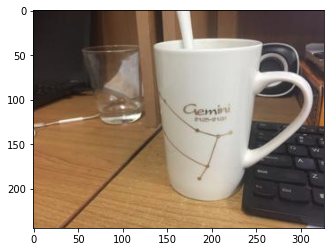

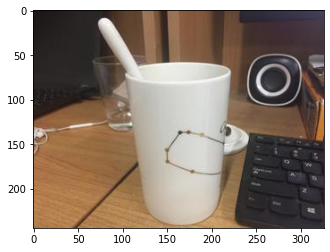

In [3]:
orig_name = "cup_a.jpg"
fake_name = "cup_b.jpg"

plt.imshow(Image.open(fake_name))
plt.show()
plt.imshow(Image.open(orig_name))

##### PatchMatch Images reconstruction

initialization
Iter : 1, score : 109.07179313289456
Iter : 2, score : 69.77316316429574
Iter : 3, score : 57.517586586133554
Iter : 4, score : 49.800379524400185
Iter : 5, score : 45.94184525405925
Iter : 6, score : 43.406029763168576
Iter : 7, score : 41.68141717977658
Iter : 8, score : 40.33919812840598
Iter : 9, score : 38.80649947757775
Iter : 10, score : 37.95386923054001


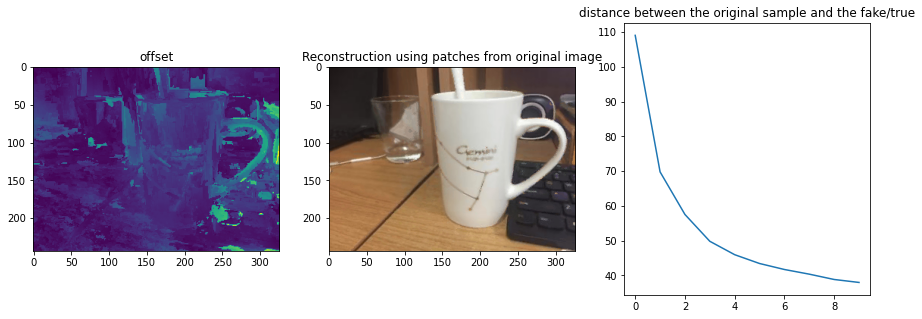

In [4]:
orig_name = "cup_a.jpg"
fake_name = "cup_b.jpg"

# Philosophy: being able to spot a fake is the same skill as producing a fake
dic_avatar = main(orig_name, fake_name, p_size = 3)

We can see that with very small patch sizes, we lose the priority of spatial regularity and the resulting image is very fragmented.

initialization
Iter : 1, score : 137.55711535614108
Iter : 2, score : 88.5120352292791
Iter : 3, score : 75.32392713350356
Iter : 4, score : 68.66646409185132
Iter : 5, score : 64.97522943160273
Iter : 6, score : 62.76632669410082
Iter : 7, score : 60.81109351777353
Iter : 8, score : 59.393348080587124
Iter : 9, score : 58.57030941179538
Iter : 10, score : 57.35557016428829


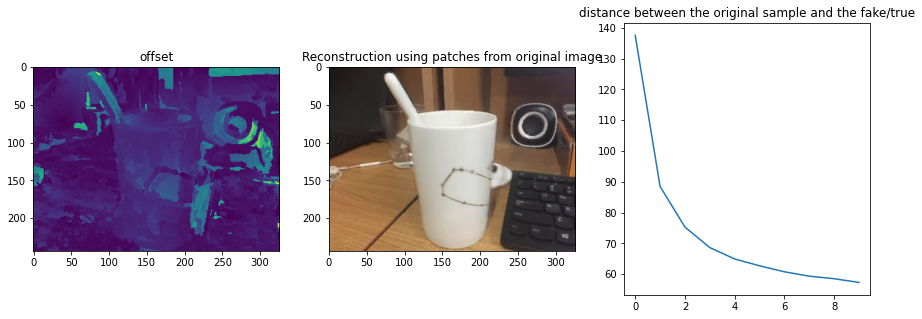

In [ ]:
fake_name = "cup_a.jpg"
orig_name = "cup_b.jpg"

dic_mona_lisa = main(orig_name, fake_name)

### Calculation of the patchMatch file for different images generated via different algorithms.

#### Singan

initialization
Iter : 1, score : 138.95694499977787
Iter : 2, score : 80.64436493920951
Iter : 3, score : 66.46031587365054
Iter : 4, score : 58.679763048484304
Iter : 5, score : 55.17434160595022
Iter : 6, score : 52.846634725739335
Iter : 7, score : 50.85028280354525
Iter : 8, score : 49.07290879944319
Iter : 9, score : 47.96327672634649
Iter : 10, score : 47.091718405230495


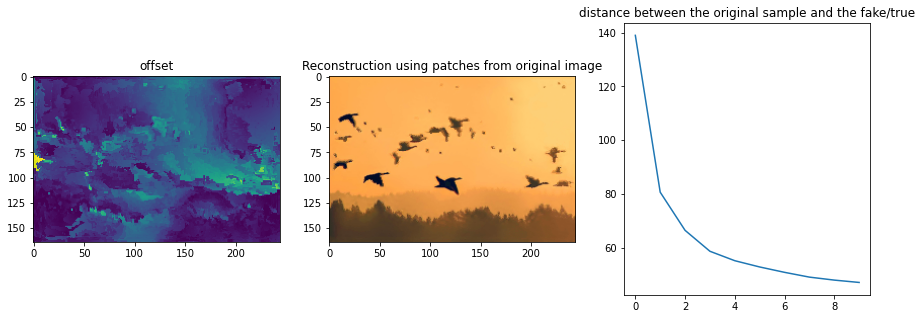

initialization
Iter : 1, score : 181.90757872776814
Iter : 2, score : 96.42291311253275
Iter : 3, score : 71.93298579642217
Iter : 4, score : 65.83235806834674
Iter : 5, score : 61.73621530554445
Iter : 6, score : 58.73859662153657
Iter : 7, score : 56.95620542986509
Iter : 8, score : 55.886083592026154
Iter : 9, score : 54.59357708536956
Iter : 10, score : 53.254018124231784


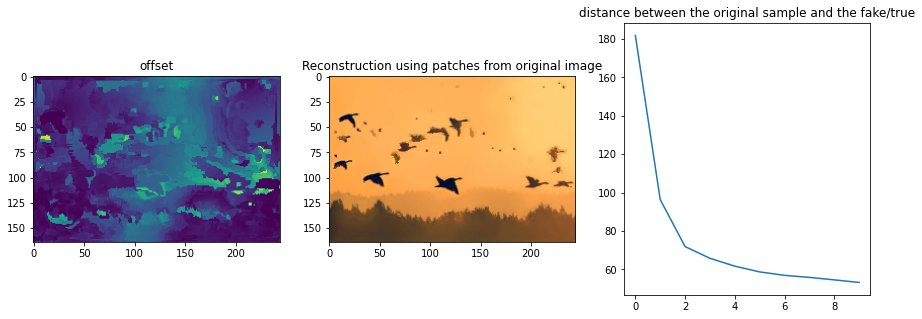

initialization
Iter : 1, score : 203.30283424697012
Iter : 2, score : 125.93048623695839
Iter : 3, score : 110.18850988280046
Iter : 4, score : 103.16500364305335
Iter : 5, score : 100.145349272092
Iter : 6, score : 97.73005175778329
Iter : 7, score : 91.6860044342996
Iter : 8, score : 87.65197940287226
Iter : 9, score : 86.35148751582135
Iter : 10, score : 86.01562072520764


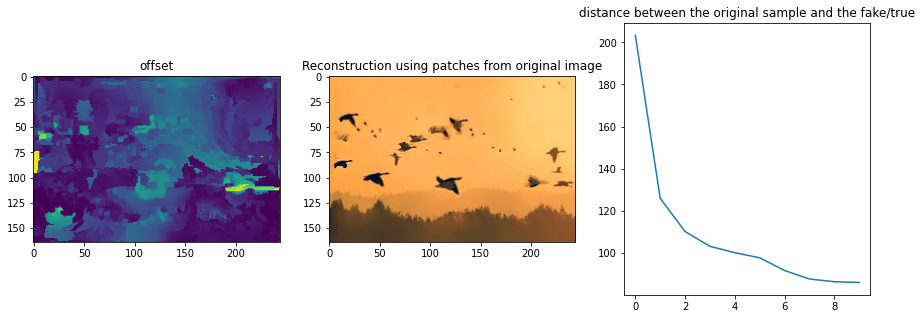

initialization
Iter : 1, score : 249.86591061544408
Iter : 2, score : 135.68527272579016
Iter : 3, score : 113.53402733168643
Iter : 4, score : 107.40309073607607
Iter : 5, score : 103.95297993535249
Iter : 6, score : 100.61616924724949
Iter : 7, score : 99.76836791481364
Iter : 8, score : 99.14586515217678
Iter : 9, score : 98.78838259074809
Iter : 10, score : 98.44357219325805


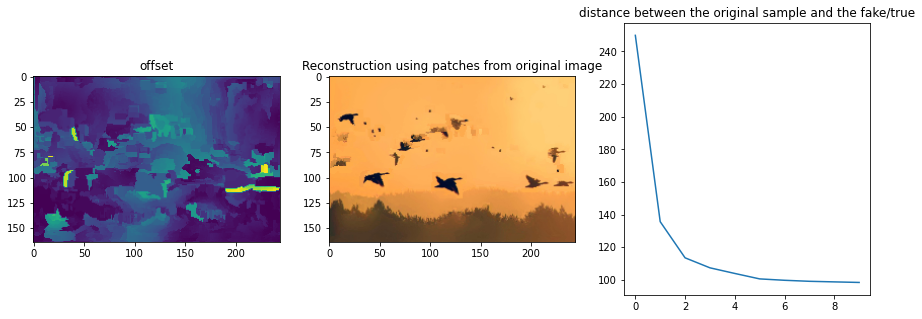

In [9]:
orig_name = "birds.png"
fake_name = "fake_sample.png"

tab_dic_birds = []

# Patch Size variation
for p_size in range(3,10,2):
    tab_dic_birds.append(main(orig_name, fake_name,  p_size=p_size))

#### Inpainting

initialization
Iter : 1, score : 4.503130099811927
Iter : 2, score : 3.0481298869341154
Iter : 3, score : 2.7435552168021684
Iter : 4, score : 2.5247445466257945
Iter : 5, score : 2.253026789284286
Iter : 6, score : 2.229070010884535
Iter : 7, score : 2.206312002976587
Iter : 8, score : 2.198649456883913
Iter : 9, score : 2.196959799413568
Iter : 10, score : 2.1830136834155227


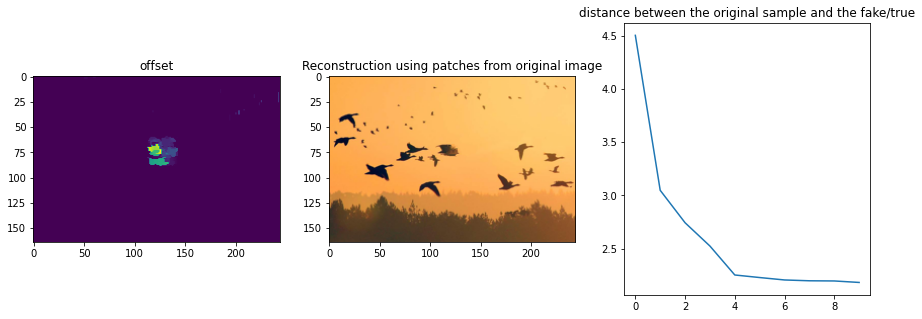

In [ ]:
orig_name = "birds.png"
fake_name = "inpainting_birds.png"

dic_inpaint = main(orig_name, fake_name)

#### CopyPaste

initialization
Iter : 1, score : 25.05589671538792
Iter : 2, score : 1.2948916451937744
Iter : 3, score : 1.0008024891895095
Iter : 4, score : 0.986551078642617
Iter : 5, score : 0.9792483608408489
Iter : 6, score : 0.97509890951027
Iter : 7, score : 0.96897155489656
Iter : 8, score : 0.9654214471618762
Iter : 9, score : 0.9550896909754616
Iter : 10, score : 0.9524725156233802


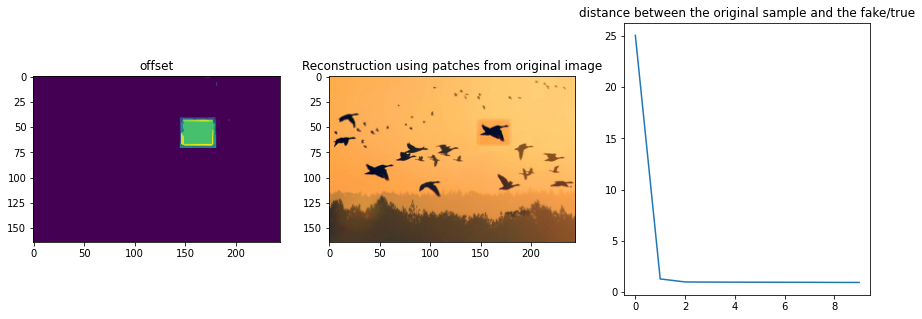

In [ ]:
orig_name = "birds.png"
fake_name = "birds_copypaste.png"

dic_copypaste = main(orig_name, fake_name)

#### SInGAN with different Generation Scale 

initialization
Iter : 1, score : 236.52759442750678
Iter : 2, score : 140.135969510344
Iter : 3, score : 118.39043832698404
Iter : 4, score : 109.9831219664912
Iter : 5, score : 104.11235063150664
Iter : 6, score : 98.06511026607876
Iter : 7, score : 92.13879656933521
Iter : 8, score : 89.30619520016069
Iter : 9, score : 87.26286497206672
Iter : 10, score : 85.76999273670162


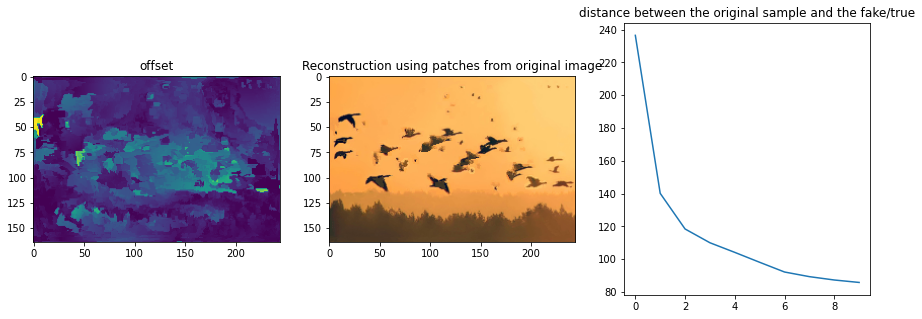

initialization
Iter : 1, score : 132.65664633683565
Iter : 2, score : 49.285910619548474
Iter : 3, score : 31.63035605665141
Iter : 4, score : 28.933467358427
Iter : 5, score : 28.37990332107898
Iter : 6, score : 27.84711973775305
Iter : 7, score : 27.37083060525789
Iter : 8, score : 26.808683665422716
Iter : 9, score : 26.37473299569061
Iter : 10, score : 25.784882276256166


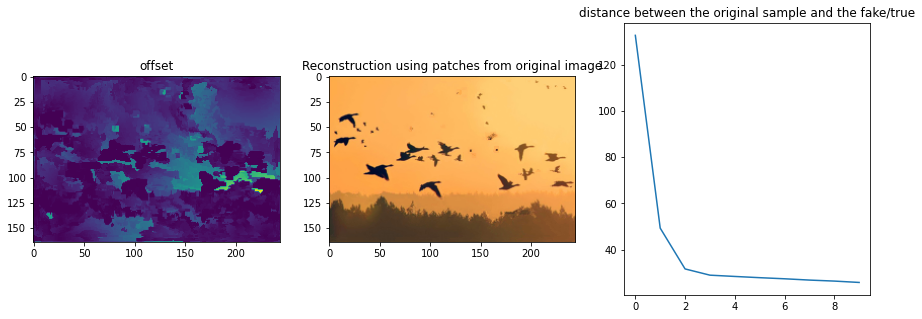

initialization
Iter : 1, score : 133.40520102375717
Iter : 2, score : 31.176822338194352
Iter : 3, score : 26.982434186047804
Iter : 4, score : 25.1577689618597
Iter : 5, score : 23.380560118545173
Iter : 6, score : 20.753183323892664
Iter : 7, score : 20.539223414800748
Iter : 8, score : 20.09551094608453
Iter : 9, score : 19.921723525867428
Iter : 10, score : 19.883647015730745


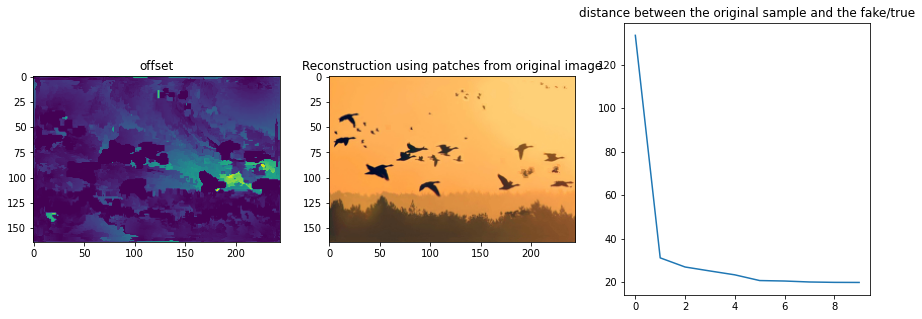

initialization
Iter : 1, score : 167.0146228661313
Iter : 2, score : 63.29321961955957
Iter : 3, score : 48.979062273238846
Iter : 4, score : 46.08141066027293
Iter : 5, score : 43.83524468684748
Iter : 6, score : 41.65293581410029
Iter : 7, score : 38.45039638079953
Iter : 8, score : 37.89017360879723
Iter : 9, score : 37.50447369431856
Iter : 10, score : 37.41187616851408


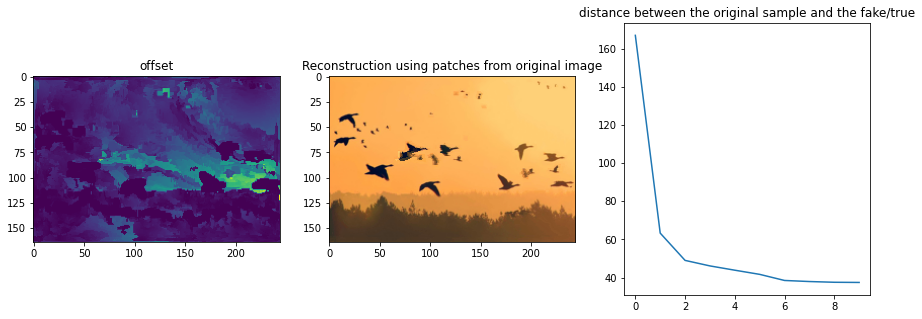

initialization
Iter : 1, score : 186.04521253304233
Iter : 2, score : 82.43655071767589
Iter : 3, score : 57.66985612236588
Iter : 4, score : 47.41875160352525
Iter : 5, score : 24.1777339342041
Iter : 6, score : 17.089311044100878
Iter : 7, score : 15.516797172334769
Iter : 8, score : 15.396391718775451
Iter : 9, score : 15.267406359215574
Iter : 10, score : 15.099217815188739


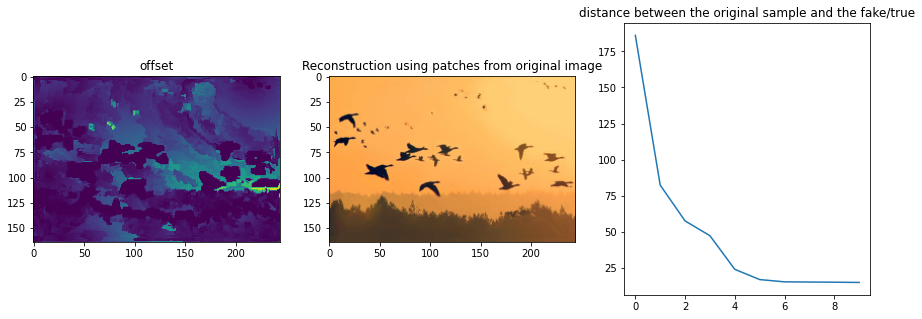

initialization
Iter : 1, score : 171.1862348070031
Iter : 2, score : 70.53486712490928
Iter : 3, score : 60.427528400676756
Iter : 4, score : 53.496073230430056
Iter : 5, score : 49.34062611066685
Iter : 6, score : 48.10348738745243
Iter : 7, score : 47.26645524660506
Iter : 8, score : 34.480206901035885
Iter : 9, score : 23.821323762161803
Iter : 10, score : 23.51716598082989


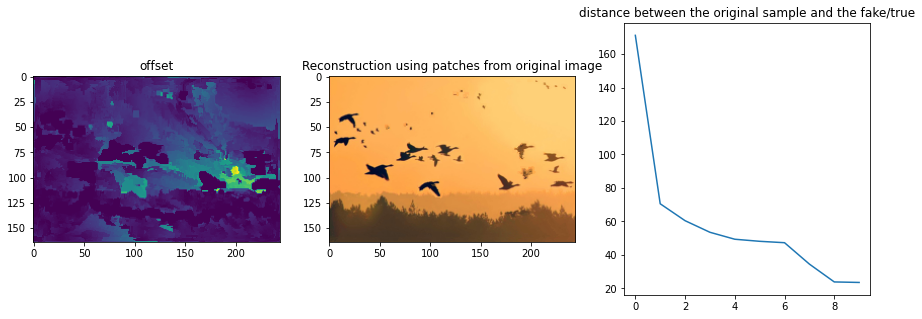

initialization
Iter : 1, score : 160.10141340685948
Iter : 2, score : 83.81795659282582
Iter : 3, score : 62.604061132491445
Iter : 4, score : 41.964517290306105
Iter : 5, score : 28.547174715761845
Iter : 6, score : 27.64230825493877
Iter : 7, score : 26.740966867882477
Iter : 8, score : 26.058980467997984
Iter : 9, score : 23.235036406733602
Iter : 10, score : 23.006031703059513


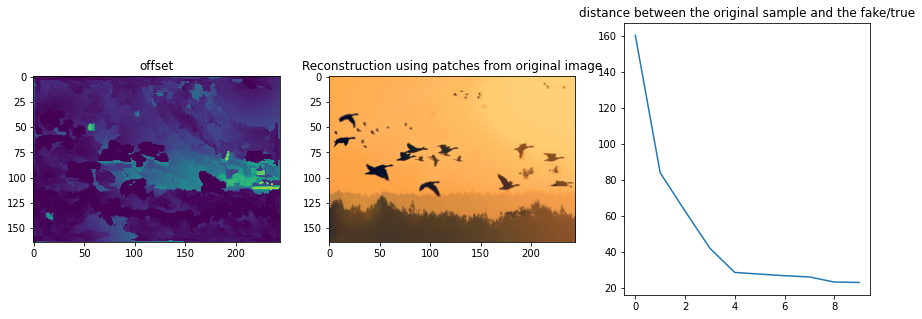

initialization
Iter : 1, score : 197.188895906915
Iter : 2, score : 72.71499302593777
Iter : 3, score : 51.42091610346602
Iter : 4, score : 46.944596675218804
Iter : 5, score : 40.0693025729523
Iter : 6, score : 38.36353236945963
Iter : 7, score : 36.846406680383396
Iter : 8, score : 36.010921145430714
Iter : 9, score : 35.12764191082825
Iter : 10, score : 30.28257902857376


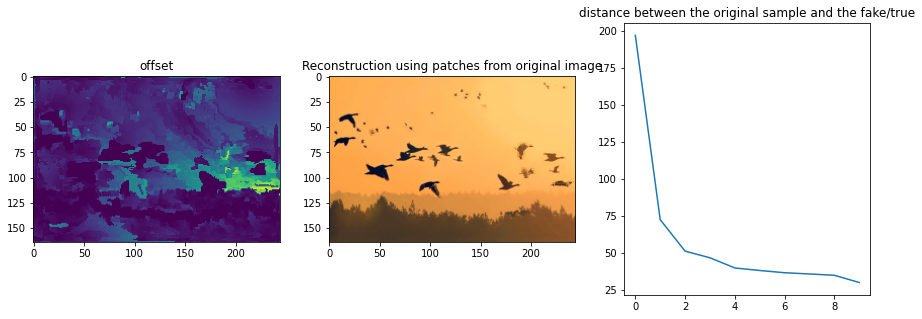

In [ ]:
tab_dic_gen_scale = []
for scale in range(8):    
    orig_name = "birds.png"
    fake_name = f"gen_scale_{scale}/0.png"

    tab_dic_gen_scale.append(main(orig_name, fake_name))

### Patch Origin Analysis

#### Originality

##### Global originality

In [ ]:
def delete_offset(dic):
    natural_offset_i = np.zeros_like(dic["fi"])
    for i in range(dic["fi"].shape[0]):
        natural_offset_i[i, :] = i
    
    natural_offset_j = np.zeros_like(dic["fj"])
    for j in range(dic["fj"].shape[1]):
        natural_offset_j[:, j] = j

    return dic["fi"]-natural_offset_i, dic["fj"]-natural_offset_j

def gradient(field):
    # normalize before ?

    df_dx = field[:-1, :1] - field[1:, :1] 
    df_dy = field[:1, :-1] - field[:1, 1:]

    grad_squared = ((df_dx * df_dx) + (df_dy * df_dy))
    L2_norm = np.sum(grad_squared)
    return grad_squared, L2_norm, df_dx, df_dy

def originality_L2_grad(dic):
    # Warning: this is not an absolute metric, but to compare between
    # two creations of the same size from the same image
    dx, dy = delete_offset(dic)

    # Norme de l'offset de hauteur
    grad_squared_i, L2_norm_i, df_dx, df_dy = gradient(dx)

    # Norme de l'offset transversal
    grad_squared_j, L2_norm_j, df_dx, df_dy = gradient(dy)

    # il y a un leger desequilibre entre les deux normes sur les images qui ne sont pas carrées mais bon...
    return np.log(L2_norm_i + L2_norm_j + 1)

def gradient_L1(field):
    # Normaliser le field avant ?

    df_dx = field[:-1, :1] - field[1:, :1] 
    df_dy = field[:1, :-1] - field[:1, 1:]

    grad_squared = np.abs(df_dx) + np.abs(df_dy) 
    L1_norm = np.sum(grad_squared)
    return grad_squared, L1_norm, df_dx, df_dy

def originality_L1_grad(dic):
    # Warning: this is not an absolute metric, but to compare between
    # two creations of the same size from the same image
    dx, dy = delete_offset(dic)

    # Norme de l'offset de hauteur
    grad_squared_i, L1_norm_i, df_dx, df_dy = gradient_L1(dx)

    # Norme de l'offset transversal
    grad_squared_j, L1_norm_j, df_dx, df_dy = gradient_L1(dy)

    # il y a un leger desequilibre entre les deux normes sur les images qui ne sont pas carrées mais bon...
    return np.log(L1_norm_i + L1_norm_j + 1)

def originality_sum_grad(dic):
    # tres stochastique  : pas image par image mais par batch d'images
    # Finalemnt pas utilisé car trop de variance

    # Warning: this is not an absolute metric, but to compare between
    # two creations of the same size from the same image
    dx, dy = delete_offset(dic)

    # Norme de l'offset de hauteur
    grad_squared_i, L2_norm_i, di_dx, di_dy = gradient(dx)

    # Norme de l'offset transversal
    grad_squared_j, L2_norm_j, dj_dx, dj_dy = gradient(dy)

    # il y a un leger desequilibre entre les deux normes sur les images qui ne sont pas carrées mais bon...
    return np.sum(di_dx + di_dy + dj_dx + dj_dy)


def angle(x,y):
    np.seterr(divide='ignore')

    # x y are two fields
    return (np.pi*(x<0) + np.arctan(y/x) + np.pi/2)/(2*np.pi)


def histogram_directions(dic):
    # Attention : ce n'est pas une metrique absolue, mais pour comparer entre
    # deux créations de même taille à partir de la même image
    
    dx, dy = delete_offset(dic)
    dx_ = dx[dx != 0]
    dy_ = dy[dx != 0]

    map_angle = angle(dx_,dy_)
    map_angle = map_angle.flatten()

    return map_angle

def nb_set(dic):
    # Donne une borne inférieure du nombre de portions constantes par morceaux
    # Attention : ce n'est pas une metrique absolue, mais pour comparer entre
    # deux créeations de même taille à partir de la même image
    
    dx, dy = delete_offset(dic)

    dx = dx.flatten()
    dy = dy.flatten()

    Z = zip(list(dx), list(dy))
    return len(set(Z))

##### Bird by bird originality

In [ ]:
def find_birds(dic):
    is_bird = np.array(Image.open(dic["fake_name"]).convert('LA'))
    is_bird = is_bird[:, :, 0]

    treshold = 90
    is_bird[is_bird < treshold] = True
    is_bird[is_bird > treshold-1] = False
    is_bird[120:,:] = False

    return is_bird

    
def find_connected_components(is_bird):
    from scipy.ndimage.measurements import label

    array = is_bird  # your image
    structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
    labeled, ncomponents = label(array, structure)

    return labeled, ncomponents


def evaluate_copy_by_bird(is_bird, dic):

    labeled, ncomponents = find_connected_components(is_bird)

    indices = np.indices(is_bird.shape).T[:,:,[1, 0]]

    import itertools

    dx, dy = delete_offset(dic)

    im_copy_birds = np.zeros_like(dx, dtype=float)

    for component in range(1, ncomponents):
        # the first connected component is the backgroung
        tab_indice = indices[labeled.T == component]

        if len(tab_indice) > 10:
            # We keep only the big birds

            tab_dot = []
            for indice1,indice2 in itertools.product(tab_indice,tab_indice):
                grad1 = np.array([dx[indice1[1], indice1[0]],
                                dy[indice1[1], indice1[0]]])
                grad2 = np.array([dx[indice2[1], indice2[0]],
                                dy[indice2[1], indice2[0]]])
                
                n1, n2 = np.linalg.norm(grad1),np.linalg.norm(grad2)
                if n1 and n2: 
                    grad1 = grad1/ n1
                    grad2 = grad2/ n2

                    # the more the dot is big, the more the vectors are aligned, the more there is copy
                    dot = np.dot(grad1,grad2)
                    tab_dot.append(dot)

            # produit scaliare moyen entre differents offset d'un oiseau
            # On met une limite de 5 pour réduire un peu la variance
            mean_dot = np.mean(np.array(tab_dot)) if len(tab_dot) > 4 else 1
            

            for indice1 in tab_indice:
                im_copy_birds[indice1[1], indice1[0]] = mean_dot

    return im_copy_birds

The MeanDotProduct code (evaluate_copy_by_bird) was built for the special case of the bird image. But it is possible to adjust it for all objects. Birds are handy because it is enough to define a brightness threshold but potentially on another image, the user would just have to define an area with the mouse to calculate the normalized scalar product in order to define the calculation area of the mean scalar product.

### Analysis of originality

In [ ]:
def plot_arrow(ax, x, y, fi, fj, axn, alpha=1):
    for i in range(0,len(x)):
        # pt de depart
        y0 = fi[y[i], x[i]]
        x0 = fj[y[i], x[i]]
        ax[0,axn].arrow(x0, y0, # point de départ de la fleche
                    x[i]-x0, y[i]-y0, alpha=alpha) # dx,dy

def global_originality(dic, coord,title_fake, save):
    name_img, name_fake_img = dic["orig_name"], dic["fake_name"]
    fi, fj = dic["fi"], dic["fj"]

    w, h = Image.open(name_img).size

    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25,7))
    #st = fig.suptitle("Analysis of "+title_fake+" using patches of size "+str(dic["p_size"]), y=0.75)
    st = fig.suptitle("Analysis of "+title_fake+" using patches of size "+str(dic["p_size"]))

    ax[0,0].imshow(Image.open(name_img))
    ax[0,0].set_title('original')

    ax[0,1].imshow(Image.open(name_fake_img))
    ax[0,1].set_title("fake")

    ax[0,2].imshow(Image.open(name_img))
    ax[0,2].set_title('vector field (selected locations)')

    ax[0,3].imshow(Image.open(name_img), alpha=0.6, cmap='jet')
    ax[0,3].imshow(np.array(Image.open(name_fake_img)), alpha=0.2)
    ax[0,3].set_title('vector field map with both images')

    ax[1,0].imshow(dic["RGB_offset"], alpha=1)
    ax[1,0].set_title('full vector field map (norm L2 /max norm)')

    ax[1,1].imshow(dic["reconstruction"], alpha=1)
    ax[1,1].set_title('reconstruction')

    for k, (x,y) in coord.items():

        plot_arrow(ax, x, y, fi, fj, axn=3)
        plot_arrow(ax, x, y, fi, fj, axn=2)

        x1, y1 = np.min(x), np.min(y)
        ax[0,2].add_patch(Rectangle((x1, y1), np.max(x)-x1, -y1+np.max(y), fill=None))
        ax[0,1].add_patch(Rectangle((x1, y1), np.max(x)-x1, -y1+np.max(y), fill=None))
        ax[0,3].add_patch(Rectangle((x1, y1), np.max(x)-x1, -y1+np.max(y), fill=None))
    
    # generate a grid
    x = np.arange(0, w, 8)
    y = np.arange(0, h, 8)
    cartesian_prod = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    x_ = cartesian_prod[:, 0]
    y_ = cartesian_prod[:, 1]

    ax[0,2].set(xlim=(0, w), ylim=(0, h))
    ax[0,2].invert_yaxis()

    # calcul des metriques
    print(" ")
    print(" ")
    print("originality_L2_grad", originality_L2_grad(dic))
    print("originality_L1_grad", originality_L1_grad(dic))
    print("originality_sum_grad", originality_sum_grad(dic))
    print("nb_set", nb_set(dic))

    dic["originality_L2_grad"] = originality_L2_grad(dic)
    dic["originality_L1_grad"] = originality_L1_grad(dic)
    dic["originality_sum_grad"] = originality_sum_grad(dic)
    dic["nb_set"] = nb_set(dic)

    map_angle = histogram_directions(dic)

    ax[1,2].hist(map_angle)
    ax[1,2].set_title("histogramm of the angles of the offsets (rad)")
    ax2 = ax[1,2]
    ax1 = ax[1,1]
    asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
    asp /= np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
    ax2.set_aspect(asp)

    is_bird = find_birds(dic)
    im_copy_birds = evaluate_copy_by_bird(is_bird, dic)
    # On modifie le pixel en 0,0 afin de conserver le meme maximum et de plot avec la même echelle
    im_copy_birds[0,0] = 1
    img = ax[1,3].imshow(im_copy_birds)
    plt.colorbar(img, ax=ax)
    ax[1,3].set_title("mean dot-product of normalized offset by bird")
    dic["im_copy_birds"] = im_copy_birds

    plt.savefig(save)
    plt.show()

    return dic
        

#### PatchMatch  analysis of birds who were simply created through a copy with the SinGAN

 
 
 
originality_L2_grad 17.455038095155242
originality_L1_grad 13.35518791637139
originality_sum_grad 79339
nb_set 11251


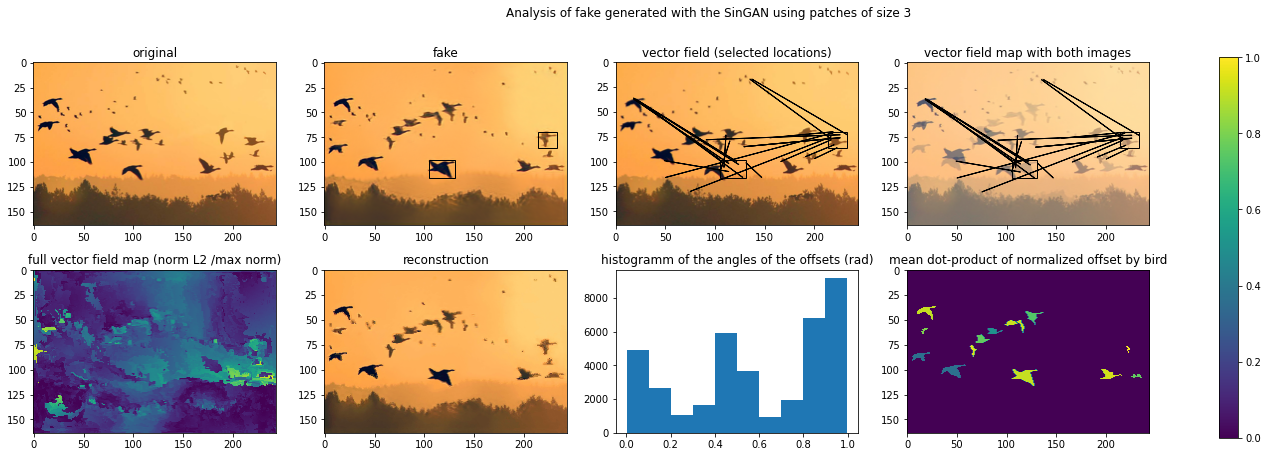

 
 
 
originality_L2_grad 15.856654520271698
originality_L1_grad 12.803870145505648
originality_sum_grad 60633
nb_set 9239


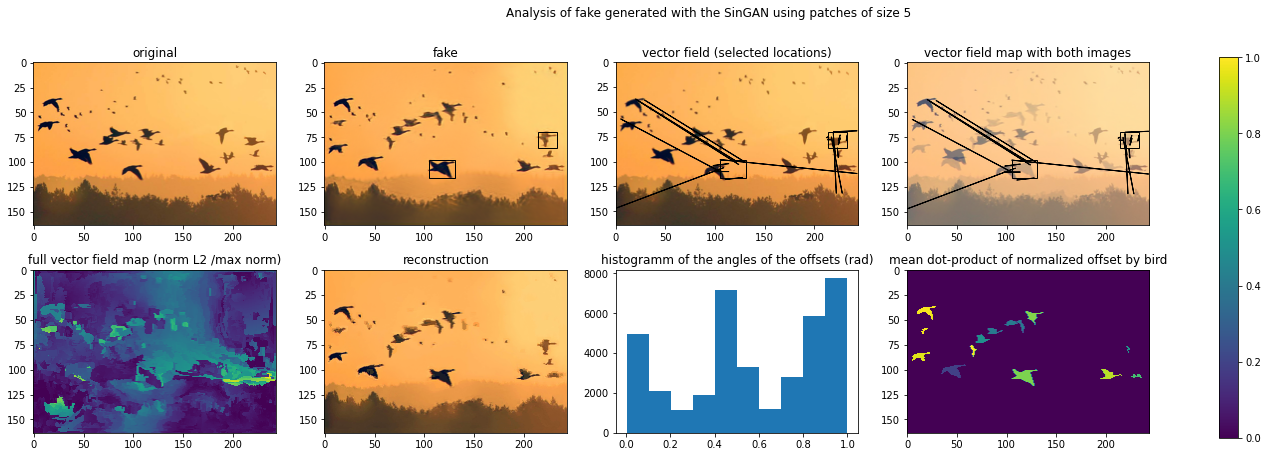

 
 
 
originality_L2_grad 14.953481050333407
originality_L1_grad 12.364635008129898
originality_sum_grad 34226
nb_set 8572


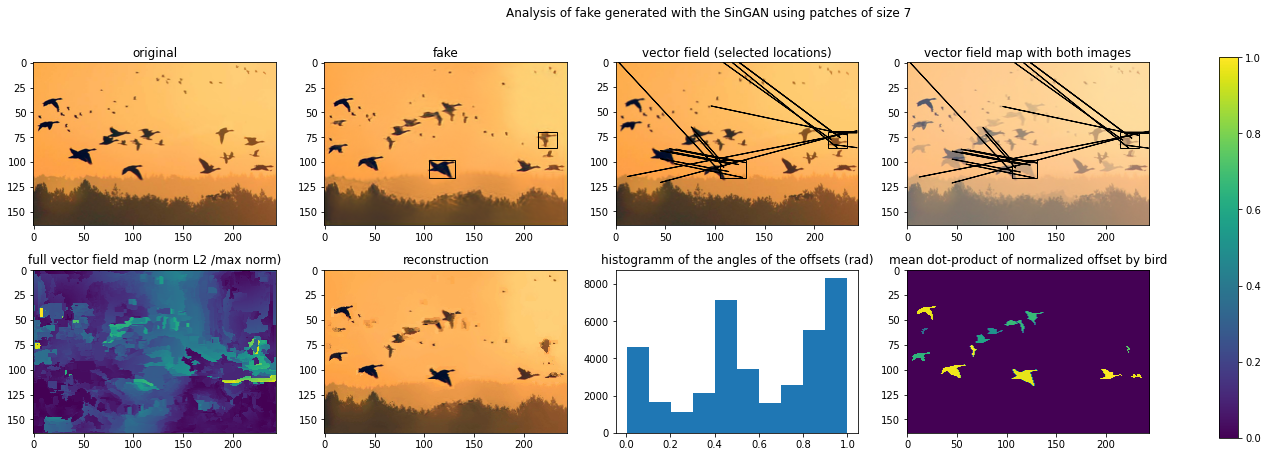

 
 
 
originality_L2_grad 17.129266724815214
originality_L1_grad 12.698290208221566
originality_sum_grad 28171
nb_set 7704


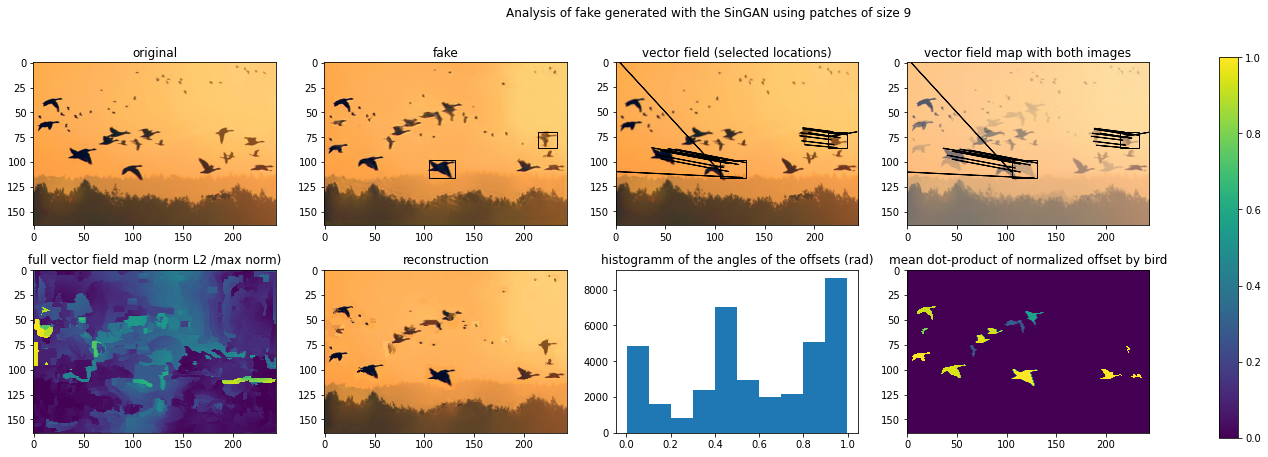

In [ ]:
coord={
    "oiseau moche":
       [
        [219, 226, 226, 233, 226, 223, 220, 217, 214, 217, 219], #x
        [70 ,  76,  73,  73, 76 ,  86,  83,  78,  75, 75 ,  71] #y
        ],
    "oiseau recopié":
       [
        [105, 114, 122, 131, 124, 128, 114, 105, 109], #x
        [98 , 102, 100, 101, 103, 116, 110, 110, 106] #y
        ],
    }
results = []
for dic_birds in tab_dic_birds:
    print(" ")
    dic = global_originality(dic_birds, coord,
                    title_fake="fake generated with the SinGAN",
                    save=f"result_birds_singan_p_size{dic_birds['p_size']}.png")
    results.append(dic)

The patches of size 5 give the best results.

#### Inpainting

 
 
originality_L2_grad 9.236690147298965
originality_L1_grad 8.037543185118697
originality_sum_grad 0
nb_set 209


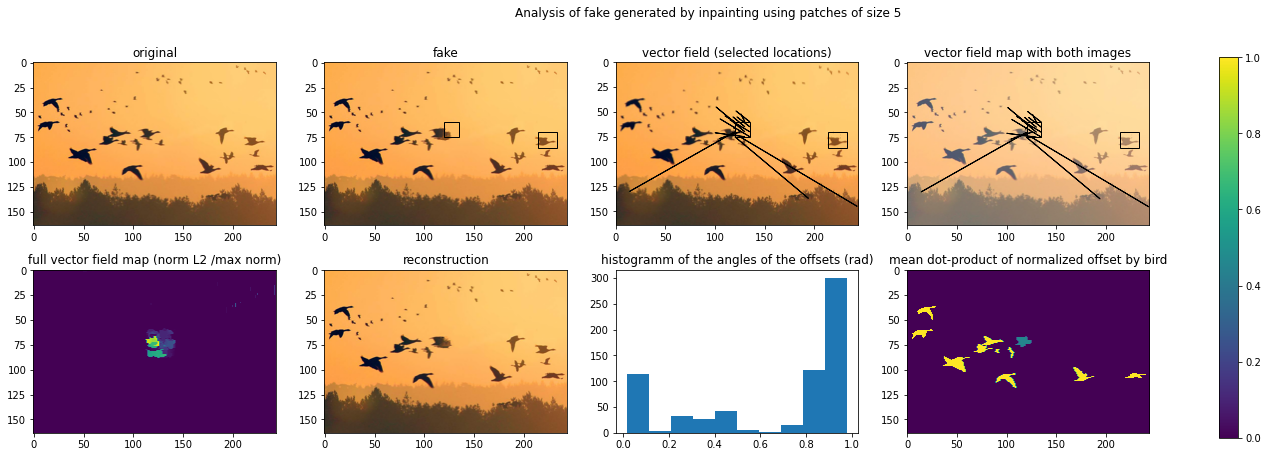

In [ ]:
x = np.arange(120, 140, 5)
y = np.arange(60, 80, 5)
cartesian_prod = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
x_ = cartesian_prod[:, 0]
y_ = cartesian_prod[:, 1]

coord={
    "zone non copiée":
       [
        [219, 226, 226, 233, 226, 223, 220, 217, 214, 217, 219], #x
        [70 ,  76,  73,  73, 76 ,  86,  83,  78,  75, 75 ,  71] #y
        ],
    "inpainted bird":
       [
        x_, y_
        ],
    }


dic = global_originality(dic_inpaint, coord,
                  title_fake="fake generated by inpainting",
                  save="result_birds_inpainting.png")
results.append(dic)

#### CopyPaste

 
 
originality_L2_grad 11.487351213850799
originality_L1_grad 9.283497892593909
originality_sum_grad 0
nb_set 245


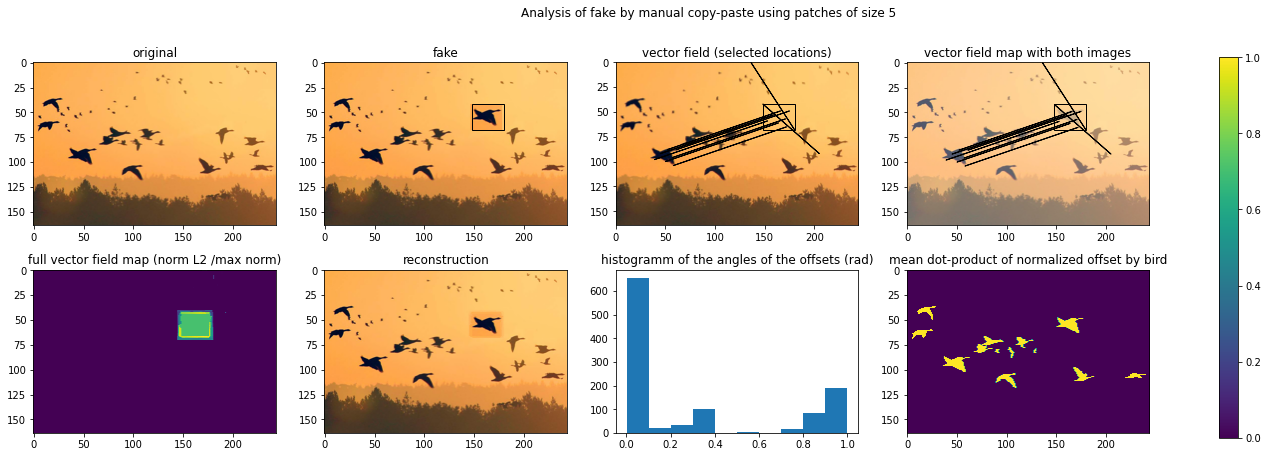

In [ ]:
coord={
    "copied bird":
       [
        [166, 159, 153, 164, 172, 171, 175, 148,180], #x
        [ 49,  53,  59,  61,  65,  57,  49, 42, 68] #y
        ],
    }

dic = global_originality(dic_copypaste, coord,
                  title_fake="fake by manual copy-paste",
                  save="result_birds_copypaste.png")

results.append(dic)

#### Generation Scale

 
 
originality_L2_grad 17.251097417802168
originality_L1_grad 13.24239632455501
originality_sum_grad 14056
nb_set 7650


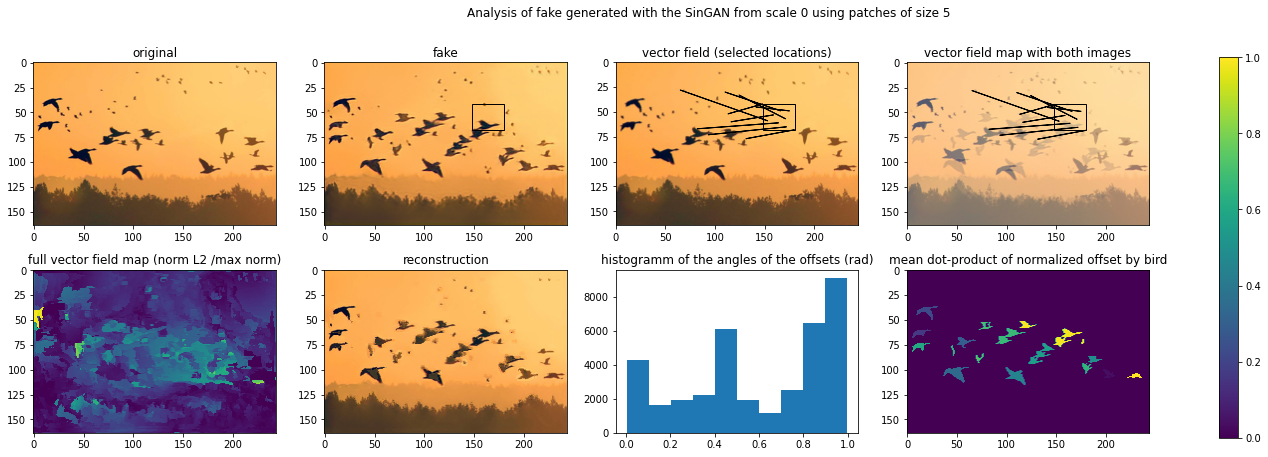

 
 
originality_L2_grad 15.168275022474115
originality_L1_grad 12.47702302055016
originality_sum_grad 1583
nb_set 5694


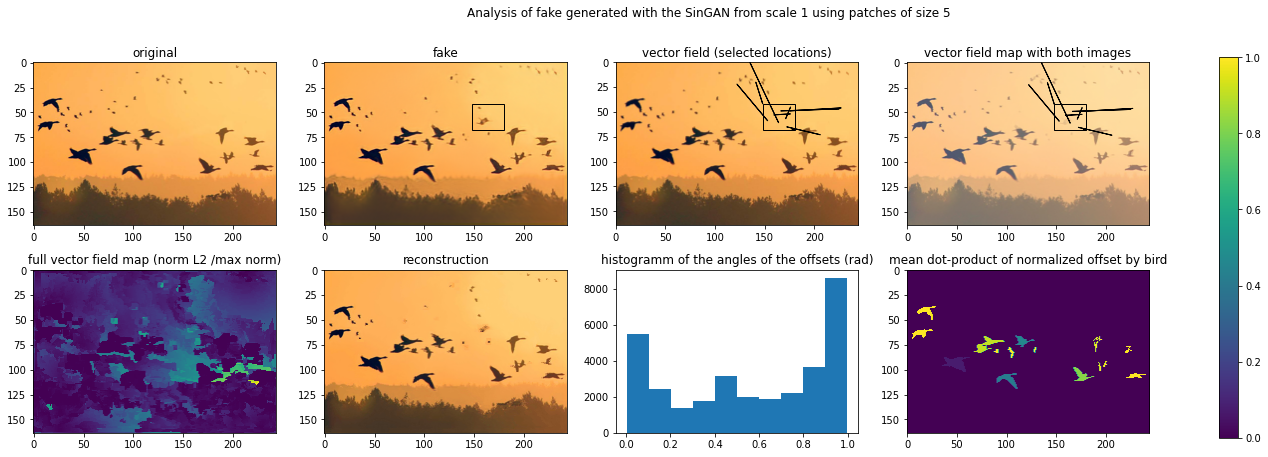

 
 
originality_L2_grad 15.773936203295364
originality_L1_grad 12.684754137969545
originality_sum_grad 15594
nb_set 5435


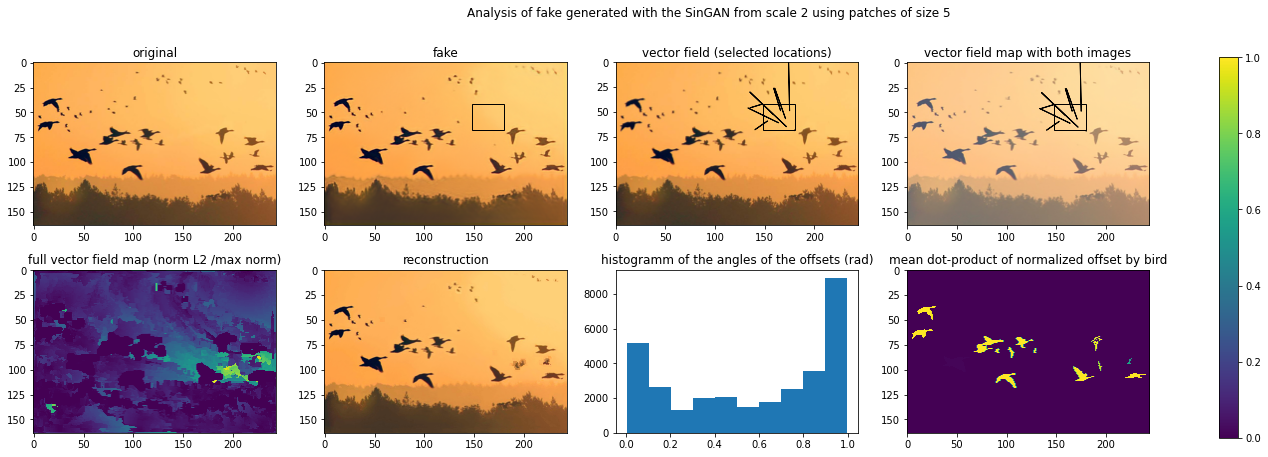

 
 
originality_L2_grad 15.519595521290405
originality_L1_grad 12.560384800279717
originality_sum_grad 15431
nb_set 5932


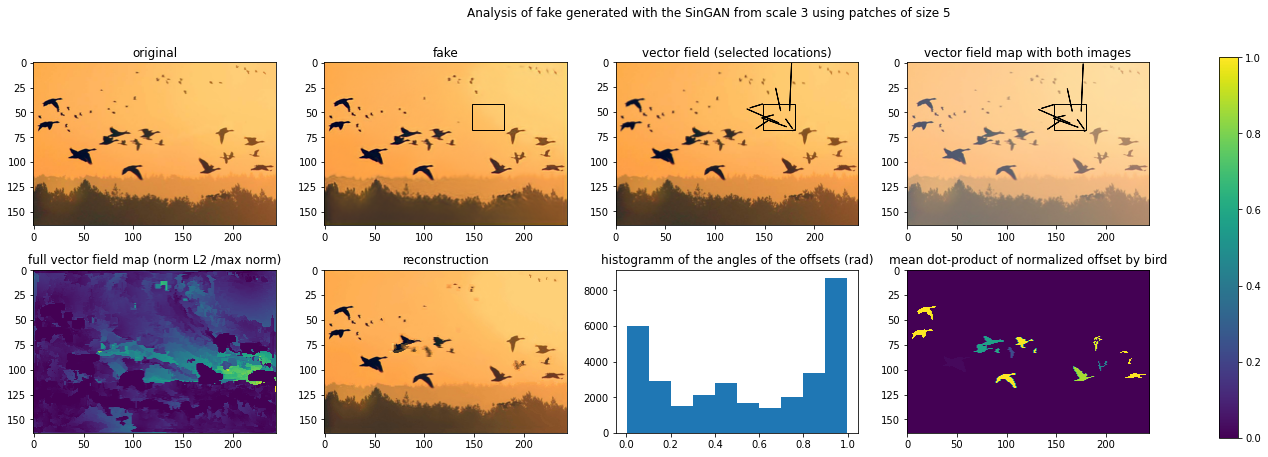

 
 
originality_L2_grad 15.228912661679287
originality_L1_grad 12.55777122789537
originality_sum_grad 6923
nb_set 5861


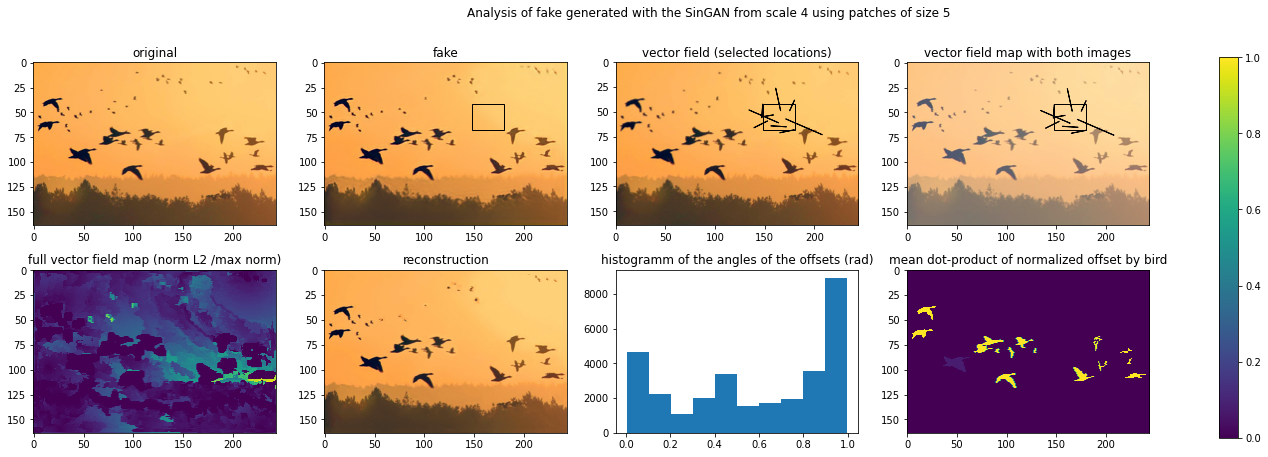

 
 
originality_L2_grad 15.77401718014139
originality_L1_grad 12.509855649507129
originality_sum_grad 14788
nb_set 5549


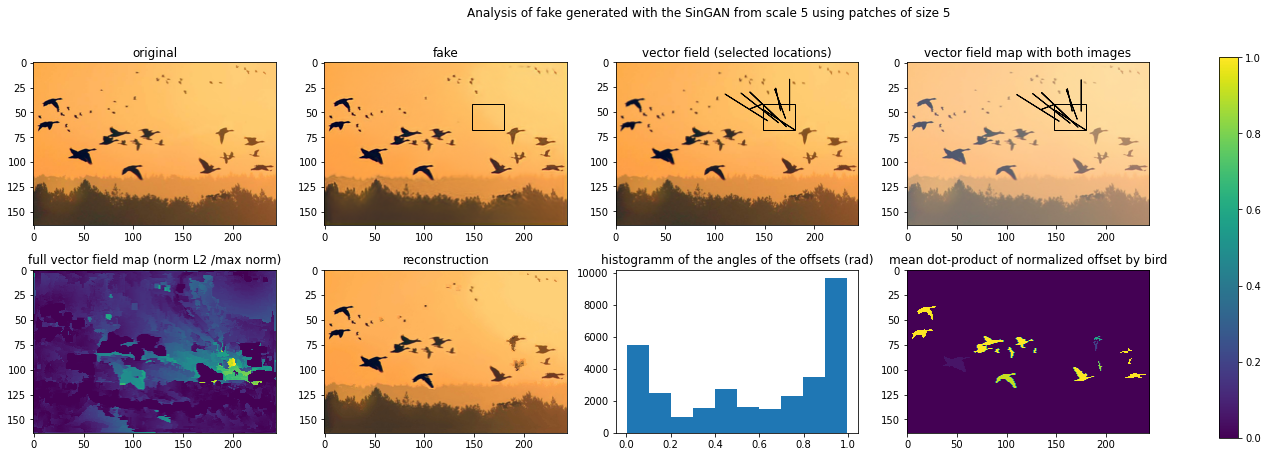

 
 
originality_L2_grad 15.267813843024484
originality_L1_grad 12.486779195495526
originality_sum_grad 6760
nb_set 5814


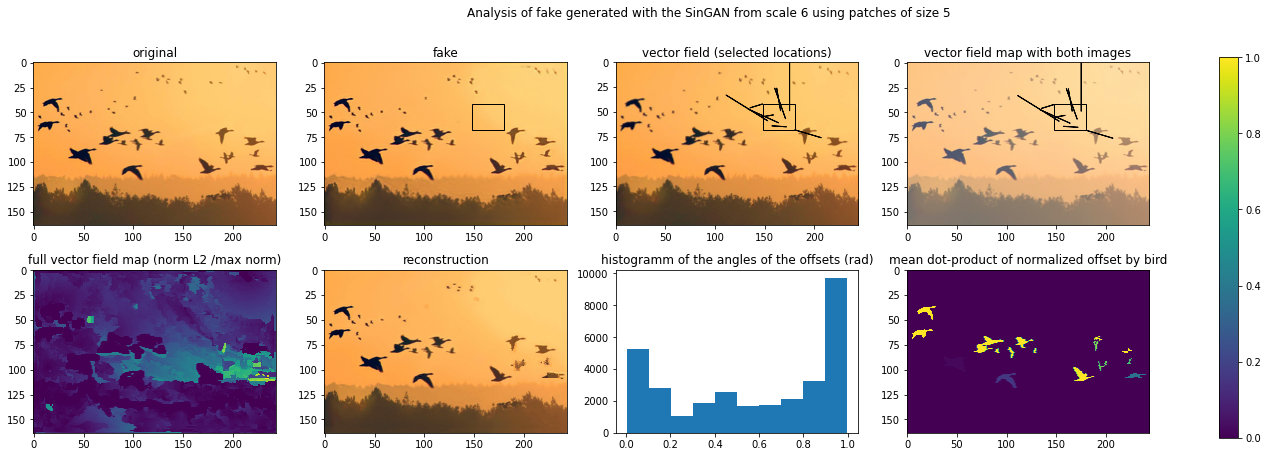

 
 
originality_L2_grad 16.05690947775141
originality_L1_grad 12.777704521675593
originality_sum_grad 13484
nb_set 6024


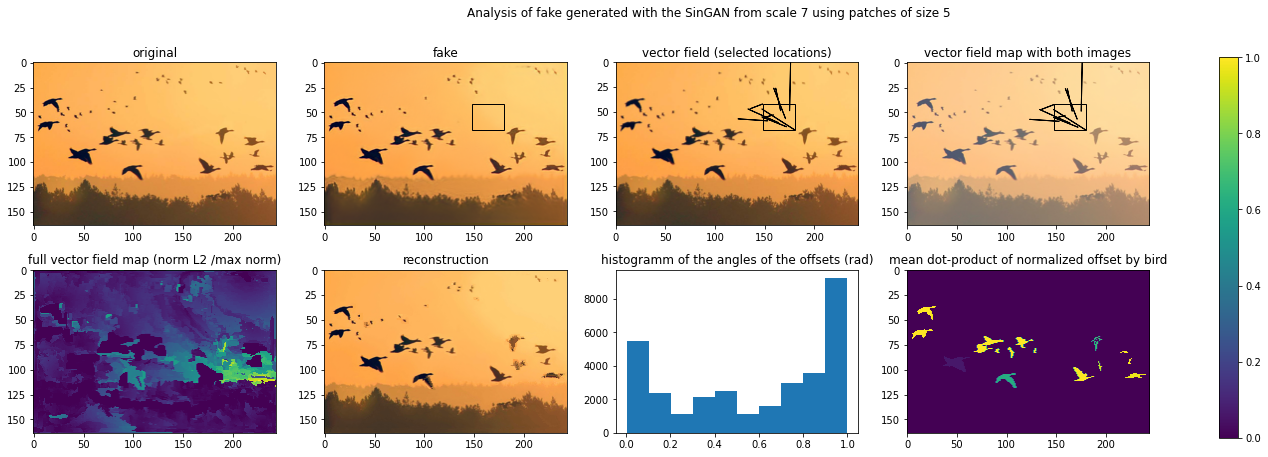

In [ ]:
coord={
    "copied bird":
       [
        [166, 159, 153, 164, 172, 171, 175, 148,180], #x
        [ 49,  53,  59,  61,  65,  57,  49, 42, 68] #y
        ],
    }

result_scale =  []

for scale,dic in enumerate(tab_dic_gen_scale):
    dic = global_originality(dic, coord,
                    title_fake=f"fake generated with the SinGAN from scale {scale}",
                    save=f"result_birds_genscale_{scale}.png")

    results.append(dic)
    result_scale.append(dic)

We can see that the birds gradually become more and more yellow as the scale increases.

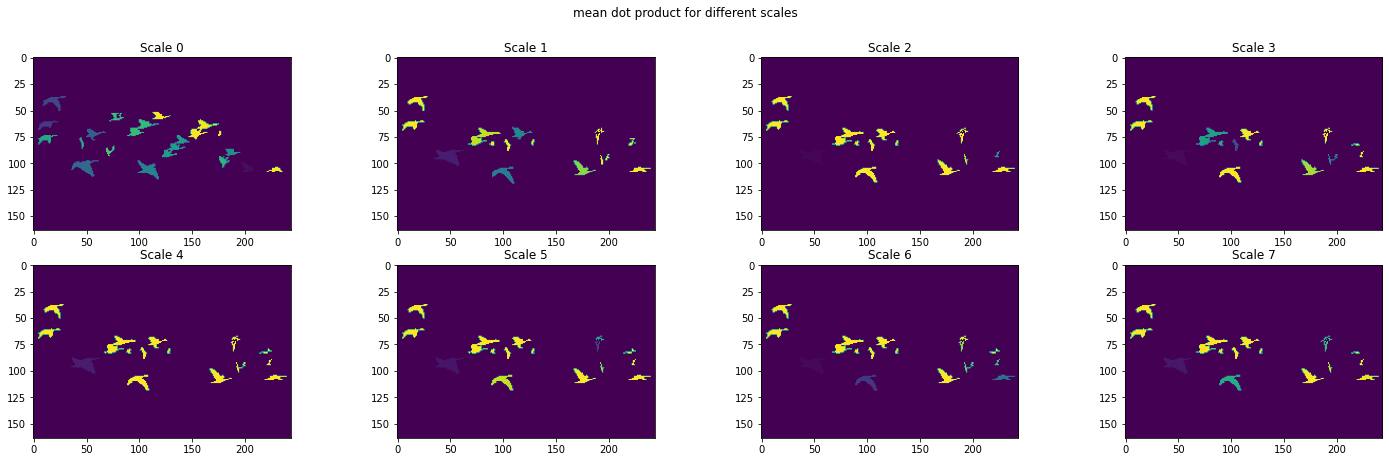

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25,7))
st = fig.suptitle("mean dot product for different scales")

for i, ax in enumerate(axs.reshape(-1)): 
  ax.imshow(result_scale[i]["im_copy_birds"])
  ax.set_title(f"Scale {i}")
plt.show()

### Results

In [ ]:
import pandas as pd

df = pd.DataFrame(results)
df = df[["orig_name", "fake_name", "p_size",	"itr", "originality_L2_grad", "originality_L1_grad",  "nb_set"]]
df

orig_name             fake_name  ...  originality_L1_grad  nb_set
0   birds.png       fake_sample.png  ...            13.355188   11251
1   birds.png       fake_sample.png  ...            12.803870    9239
2   birds.png       fake_sample.png  ...            12.364635    8572
3   birds.png       fake_sample.png  ...            12.698290    7704
4   birds.png  inpainting_birds.png  ...             8.037543     209
5   birds.png   birds_copypaste.png  ...             9.283498     245
6   birds.png     gen_scale_0/0.png  ...            13.242396    7650
7   birds.png     gen_scale_1/0.png  ...            12.477023    5694
8   birds.png     gen_scale_2/0.png  ...            12.684754    5435
9   birds.png     gen_scale_3/0.png  ...            12.560385    5932
10  birds.png     gen_scale_4/0.png  ...            12.557771    5861
11  birds.png     gen_scale_5/0.png  ...            12.509856    5549
12  birds.png     gen_scale_6/0.png  ...            12.486779    5814
13  birds.png     gen_scale_7/0.png  ...            12.777705    6024

[14 rows x 7 columns]

#### Influence of the GenScale

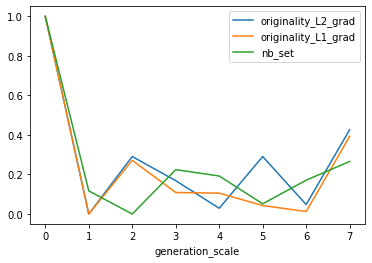

In [ ]:
cols_to_norm = ['originality_L2_grad', 'originality_L1_grad', "nb_set"]
df_ = df.loc[6:, cols_to_norm]
df_[cols_to_norm] = df_[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df_["generation_scale"] = list(range(8))
df_.set_index('generation_scale',inplace=True)
df_.plot()

We can see that there is a very big difference between the originality of the 0 scale and the other scales. Indeed, from scale 0, the global structure of the image is fixed, and we can see that the generated images are very similar to each other and we only see variations due to noise for the following generation scales.

#### Influence of the patch_size in the analysis

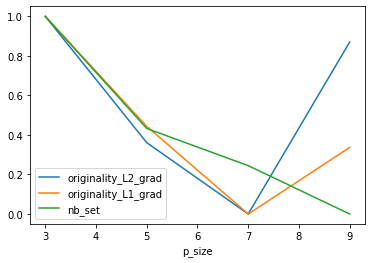

In [ ]:
cols_to_norm = ['originality_L2_grad', 'originality_L1_grad', "nb_set"]
df_ = df.loc[:3, cols_to_norm]
df_[cols_to_norm] = df_[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df_["p_size"] = list(range(3,10,2))
df_.set_index('p_size',inplace=True)
df_.plot()

One would expect to obtain a progressive decrease in originality as a function of patch size due to our interpretation of patch size as a regularization priority, which is verified for the number of sets metric which is well decreasing but is not verified for the large values for originality calculated from the L2 standard of the offsets gradient map.

In order to interpret the rise phenomenon, let's recall that nb_set describes the number of different offsets in the image which is a proxy of the number of zones with a constant offset in the image. Thus, we can see on the graph that the number of offsets decreases progressively with the size of the patch. Thus, the constant areas per patch become larger and larger. And the different zones where the copies come from become more and more distant from each other, hence the growth in L2 norm, but probably not the growth in L1 norm which penalizes less the big jumps.

-> I added the L1 norm after having made this conjecture

-> The L1 standard also goes up for a patch size of 9 but goes up less.

-> Difficult to conclude on a sample size of 1

Conclusion: it is necessary to analyze the results by fixing the size of the patches even if the variations between the calculations of the different originalities are much greater between the different techniques of fake creation (singan, copy-paste, inpainting), than between the originalities issued by different sizes of patches.